# Detect Noisy channels

In [1]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from pyprep.find_noisy_channels import NoisyChannels
subject = 601
# Add the workspace root to the Python path
workspace_root = os.path.abspath("../..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess

# Load the bad channels data
with open(os.path.join(workspace_root,'results', 'bad_channels.pkl'), "rb") as f:
    all_bad_channels = pickle.load(f)
    bad_channels = all_bad_channels[601] 

# Load the bridged channels data
with open(os.path.join(workspace_root, 'results', 'bridged_channels_analysis.pkl'), "rb") as f:
    all_bridged_channels = pickle.load(f)
    bridged_channels= all_bridged_channels[5][601] # either 5 or 16 ; 16 is a stricter threshold
    
print('Potential Bad channels:', bad_channels)
print('Bridged channels:', bridged_channels['bridged_ch_names'])

Potential Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['A30', 'B27'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['B27'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['A30', 'B27']}
Bridged channels: ['A2', 'A3', 'D3', 'D4', 'C8', 'C9', 'D19', 'D20', 'B22', 'B23', 'C28', 'C29', 'B31', 'B32']


In [3]:
subject = preprocess(601)
raw= subject.load_data()
raw = subject.Bad_segments(raw)
raw.notch_filter(50, fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq= 40)


Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_601_Def_AM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 478719  =      0.000 ...   934.998 secs...
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_601_Def_AM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 478719  =      0.000 ...   934.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
numnber of breaks found with threshold 11: 2
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


<RawEDF | O_601_Def_AM.bdf, 129 x 478720 (935.0 s), ~471.3 MiB, data loaded>

In [ ]:
%matplotlib qt 
raw.plot(use_opengl=True, block=True, n_channels=128, scalings=dict(eeg=10e-6), picks = 'eeg')

In [ ]:
%matplotlib qt
epochs = subject.epoching(raw, tmin=-1, tmax=1, baseline=(None, 0))
epochs.plot()

# removed noisy channel

In [4]:
selected_bad = {'channel_names': ['D29', 'B27', 'A30'],
                'reason': ['M_lowFreq', 'A_cor', 'A_cor'],}

raw.info['bads'] += selected_bad['channel_names']
# remove the selected bad channels from the raw data
# Remove non-EEG channels from raw.info before creating the new Raw object
eeg_picks = mne.pick_types(raw.info, eeg=True, exclude=[])
eeg_ch_names = [raw.info['ch_names'][i] for i in eeg_picks]
eeg_ch_names = [ch for ch in eeg_ch_names if ch not in selected_bad['channel_names']]
# eeg_info = mne.create_info(ch_names=eeg_ch_names, sfreq=raw.info['sfreq'], ch_types='eeg')
raw_clean = raw.copy().pick_channels(eeg_ch_names)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [5]:
raw_clean.resample(256)

<RawEDF | O_601_Def_AM.bdf, 125 x 239360 (935.0 s), ~228.4 MiB, data loaded>

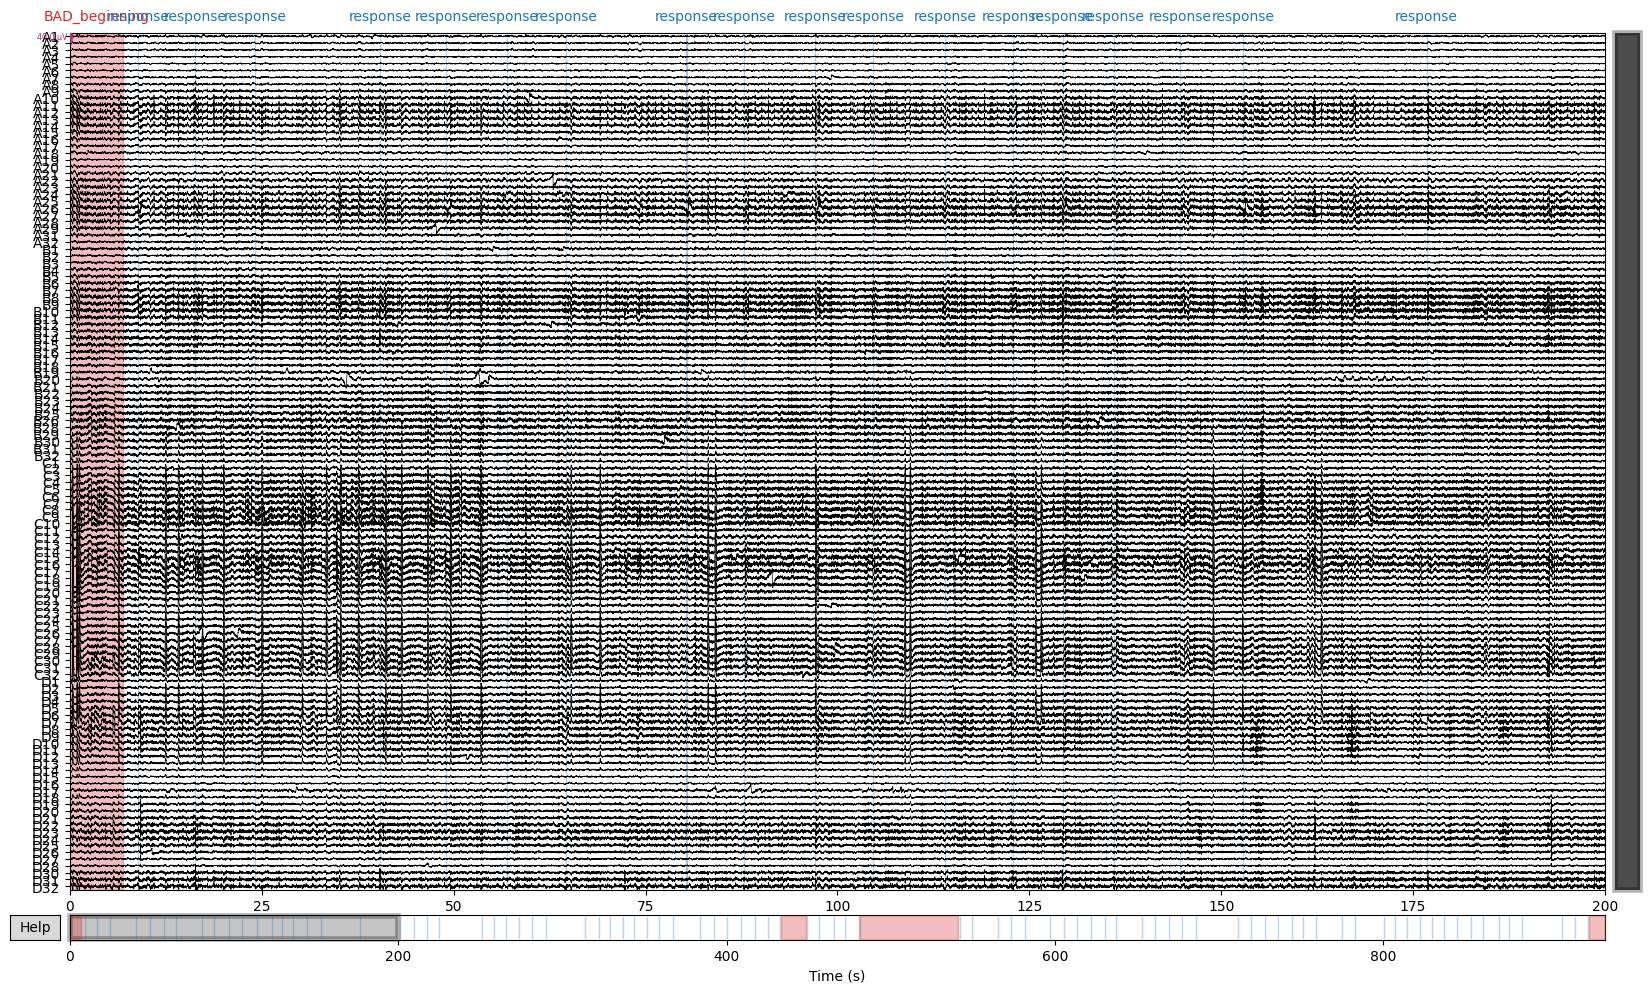

Channels marked as bad:
none


In [13]:
%matplotlib qt
raw_clean.plot(n_channels=128,duration = 200 )

In [ ]:
import asrpy
asr = asrpy.ASR(sfreq=raw_clean.info["sfreq"], cutoff=20)
asr.fit(raw_clean, start = 200, stop = 400)
raw_T = asr.transform(raw_clean)

In [ ]:

# all_selected_bad = {}
# all_selected_bad[601] = selected_bad
# # save the selected bad channels
# with open(os.path.join(workspace_root, 'results', 'selected_bad_channels.pkl'), "wb") as f:
#     pickle.dump(all_selected_bad, f)

Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated


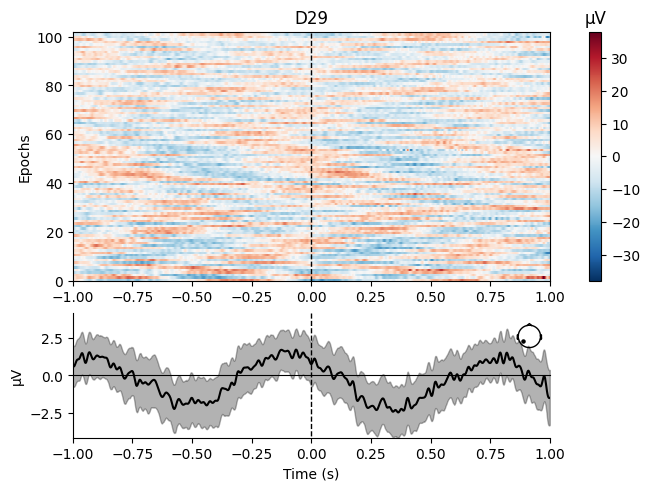

[<Figure size 640x480 with 4 Axes>]

In [16]:
%matplotlib inline
epochs.plot_image(picks = 'D29')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Need more than one channel to make topography for eeg. Disabling interactivity.


c:\Users\gmoha\anaconda3\envs\BCLenv\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


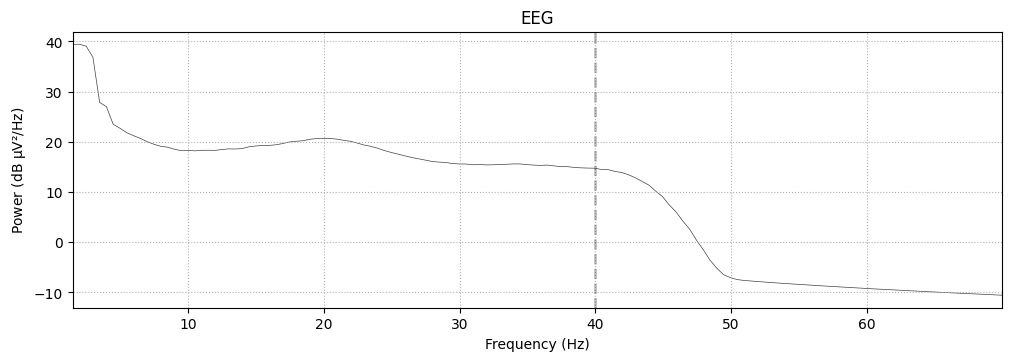

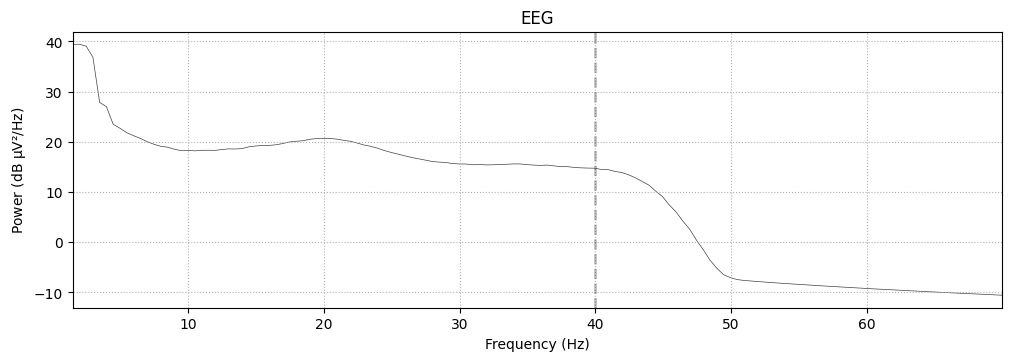

In [24]:
epochs.plot_psd(fmin=1, fmax=70, average=False, picks='D29', spatial_colors=True, n_jobs=1)

In [ ]:
from asrpy import ASR
raw = raw.resample(256)
print('Sampling frequency:', raw.info['sfreq'])

Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Sampling frequency: 256.0
